In [ ]:
from modeling.gen6.api import symbolic
from modeling.gen7.api7 import MFunctionalSet, MFunctionalSetLeaf
from engine.torchdata import print_formatted_table, load_vals
from graph.matrixview import render_incidence
from graph.graphutils import default_tree
import numpy as np

In [2]:
alpha, g, rho_w, rho, rho_h, eta_solar, m_comms, m_prop, rho, rho_h, C_d, eta_m = 0.05, 9.8, 1000, 700, 2700, 10.0, 50.0, 50.0, 700, 2700, 1.0, 0.75

d, A_solar, m_platform, m_solar, m_struct, m_batt, t_d, t_s, t_f, D_f, D_s, D_d, h_f, F_B, F_W, V_d = symbolic('d', 'A_{solar}', 'm_{platform}', 'm_{solar}', 'm_{struct}', 'm_{batt}', 't_d', 't_s', 't_f', 'D_f', 'D_s', 'D_d', 'h_f', 'F_B', 'F_W', 'V_d')

Geometry = MFunctionalSetLeaf(
    d == alpha * D_f,
    A_solar == (1 - alpha) * np.pi * (D_f / 2)**2,
    idvals = [0,1]
)  

Hydro = MFunctionalSetLeaf(
    V_d == np.pi / 4 * (D_f**2 * h_f + D_s**2 * t_s + D_d**2 * t_d),
    F_B == rho_w * V_d * g / 1000,
    F_W == F_B,
    idvals = [2,3,4]
) 

Mass = MFunctionalSetLeaf(
    m_platform == F_W * 1000 / g,
    m_solar == eta_solar * A_solar,
    m_struct == m_platform - m_batt - m_solar - m_comms - m_prop,
    t_d == (4 / np.pi * m_struct - D_f**2 * t_f * rho - D_s**2 * t_s * rho) / (D_d**2 * rho_h),
    idvals = [5,6,7,8]
)

FPF = MFunctionalSet(Geometry, Hydro, Mass)

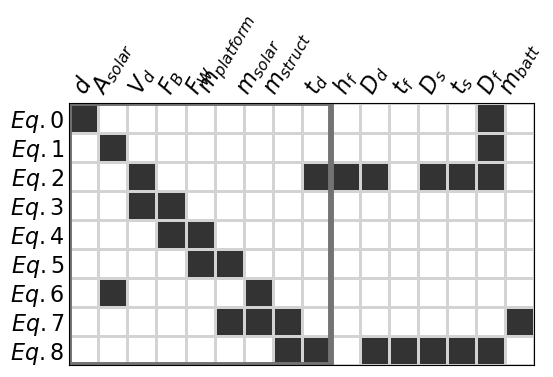

In [3]:
# get structure
sets, _,_,_, indices = FPF.gather_sets()
idxrev = {var.item():key for key,var in indices.items()}
in_outs = {eqid: D.analysis.structure for eqid, D in sets.items()}
Ein = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[0]) for eqid, item in in_outs.items()}
Eout = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[1]) for eqid, item in in_outs.items()}
edges = Ein, Eout, {}
sorted_keys = sorted(Ein.keys())
tree = default_tree(sorted_keys)
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((6,6)),diagonalgray=False);

In [4]:
FPF_MDA = FPF.config(
    elim = [Geometry],
    parallel = [Hydro, Mass]
    )

In [5]:
f = FPF_MDA.build()
idxs = f.indices

In [6]:
x0 = load_vals('applications/pearl/pearl_data/pearl_initial', 
          {str(key).replace('{','').replace('}',''):val for key,val in idxs.items()}, path_to_file='')

In [7]:
xsol = f.analysis(x0)
idxrev = {var.item():key for key,var in idxs.items()}
print_formatted_table([np.round(xsol,2)], idxs, idxrev)

t_d  A_{solar} F_W   D_d  d   F_B   t_s D_s V_d  t_f D_f m_{batt} h_f  m_{platform} m_{solar} m_{struct}
0.99 1         87.35 1.25 0.3 87.35 2   2   8.91 0.5 2   1        0.45 8913.53      29.85     8782.69   
